<a href="https://colab.research.google.com/github/zvyag/PyTorch-for-Deep-Learning-and-Computer-Vision-Course-All-Codes-/blob/master/pytorch_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import nn

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)  # change the shape (1, 28, 28) -> (28, 28, 1)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

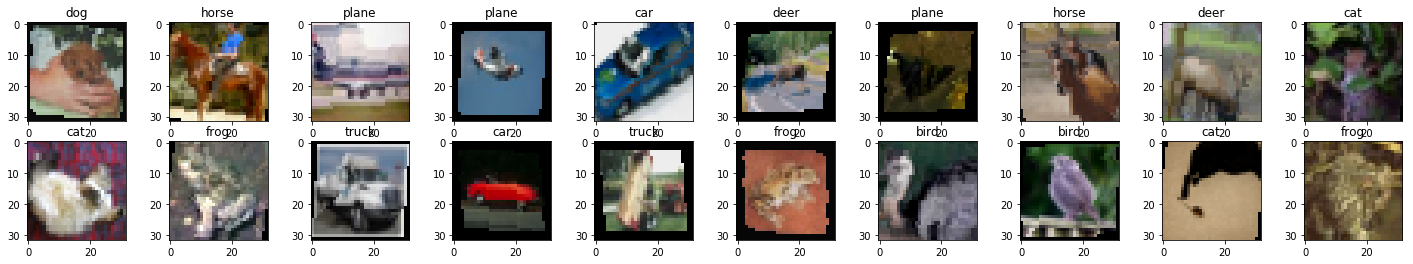

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class Classifier(nn.Module):
  
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
    
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)  # no activation function here, the output is not binary!
    return x

In [0]:
class LeNet(nn.Module):
  
  def __init__(self):
    super().__init__()
    # here we only define the layers, the network whith subsequent application of layers is described within the forward function
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)  # in_channels, out_channels, kernel_size, stride)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.fc2 = nn.Linear(500, 10)
    self.dropout1 = nn.Dropout(0.5)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)  # reducing image size in half
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [10]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5)
)

In [0]:
criterion = nn.CrossEntropyLoss()  # used for multiclass classification
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [0]:
def compute_loss(inputs, labels):
  outputs = model(inputs)  
  return criterion(outputs, labels), outputs

In [13]:
epochs = 12
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for train_in, train_label in training_loader:
    train_in = train_in.to(device)
    train_label = train_label.to(device)
    loss, out = compute_loss(train_in, train_label)  # loss computed on one batch
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(out, 1)    
    running_loss += loss.item()
    running_corrects += torch.sum(preds == train_label.data)  # number of correct predictions in each batch
  else:
    with torch.no_grad():  # to save memory
      for val_in, val_labels in validation_loader:
        val_in = val_in.to(device)
        val_labels = val_labels.to(device)
        val_loss, val_out = compute_loss(val_in, val_labels)
        
        _, val_preds = torch.max(val_out, 1)    
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)  # number of correct predictions in each batch
      
    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    
    print("epoch: ", i)
    print("training loss: {:.4f}, acc: {:.4f}".format(epoch_loss, epoch_acc.item()))
    print("validation loss: {:.4f}, val acc: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))

epoch:  0
training loss: 1.6934, acc: 37.9400
validation loss: 1.4008, val acc: 49.3100
epoch:  1
training loss: 1.3757, acc: 50.4840
validation loss: 1.1913, val acc: 56.8100
epoch:  2
training loss: 1.2365, acc: 55.7600
validation loss: 1.1217, val acc: 60.3000
epoch:  3
training loss: 1.1436, acc: 59.4340
validation loss: 1.0299, val acc: 64.0300
epoch:  4
training loss: 1.0750, acc: 61.9460
validation loss: 0.9978, val acc: 64.9700
epoch:  5
training loss: 1.0207, acc: 64.1220
validation loss: 0.9392, val acc: 67.1800
epoch:  6
training loss: 0.9849, acc: 65.1020
validation loss: 0.8874, val acc: 68.6900
epoch:  7
training loss: 0.9492, acc: 66.4260
validation loss: 0.8798, val acc: 69.2000
epoch:  8
training loss: 0.9204, acc: 67.6440
validation loss: 0.8420, val acc: 70.6400
epoch:  9
training loss: 0.8995, acc: 68.5200
validation loss: 0.8598, val acc: 70.2500
epoch:  10
training loss: 0.8768, acc: 69.5180
validation loss: 0.8017, val acc: 72.2100
epoch:  11
training loss: 0.863

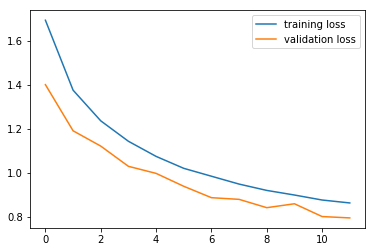

In [14]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()

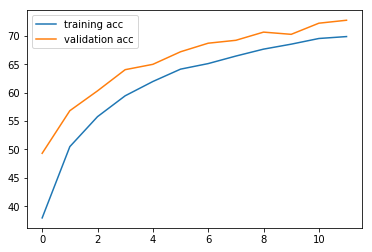

In [15]:
plt.plot(running_corrects_history, label="training acc")
plt.plot(val_running_corrects_history, label="validation acc")
plt.legend()